# VT2

In [131]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation

In [132]:
# Demand at t0
Dt0 = 22561132
# Steptime in Years
dt = 1
# Time Horizon of Forecasts in Steptime
Fth = 20
# Number of Forecasts
Forecasts = 2

# Parameters
mu = 0.042754330256447565
sigma = 0.05813761525452841

### Plotting the Scenarios

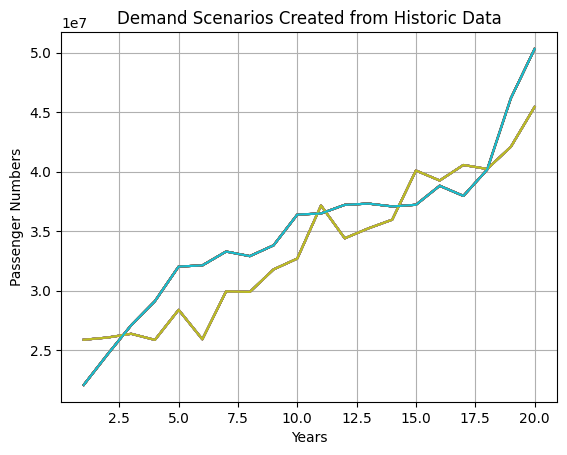

<Figure size 640x480 with 0 Axes>

In [133]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(mu, sigma, Dt0, dt, Fth, Forecasts)

# Round values up for further Calculation
Demand = np.ceil(Scenarios)
# print(D)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Scenarios,
    Fth,
    True,
    "Demand Scenarios Created from Historic Data",
    "Passenger Numbers",
    30,
)

# Need to define Capacity first!!

# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     K_rounded,
#     Fth,
#     True,
#     "Capacity",
#     "USD in Millions",
#     30,
# )

# print(np.shape(Scenarios))
# print(Scenarios)

Geometric Brownian motion Formula

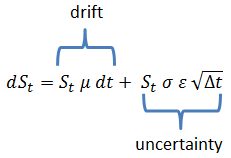

## Estimation of Dockstand Demand

In [134]:
# Percentage of Pax using Dock Stands rather than Bus Gates
p_dock = 0.8
# Percentage of Pax travelling within Schengen Area
p_schengen = 0.8
# Percentage of Pax travelling from Dock
p_Dok_A_B = 0.5
# average number of passengers carried per air traffic movement
PAXATM = 114

# Demand at design Hour
D_per_hour = Demand / (365 * 17)

# Contact Stand Demand (ZRH has 75, but not all can be used at once)
# Dock A has 17 Contact and 16 Bus Gates

d = (D_per_hour * p_dock * p_schengen * p_Dok_A_B) / PAXATM

# print("Contact Stand demad d: ", d)

### Plotting the Dockstand demand

In [135]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     d,
#     Fth,
#     True,
#     "Dockstand Demand Terminal A at ZRH",
#     "Number of Dock Stands",
#     30,
# )

## Calulation of the ENPV

In [136]:
def Capacity(K0, delta_K):
    """
    This Function returns the Capacity value for a given Initial Capacity and delta
    Capacity Vector

    Args:
        K0 (int): Initial Capacity
        delta_K (ndarray): delta Capacity Vector

    Returns:
        K (ndarray): Capacity Vector
    """
    # Create a cumulative sum array starting from K0
    K = K0 + np.cumsum(delta_K) * 1000000
    return K


def Revenue(K, D, r_K, r_K_rent, r_D):
    """
    This Function calculates the Revenue

    Args:
        K (ndarray): _description_
        D (ndarray): _description_
        r_K (float): _description_
        r_K_rent (float): _description_
        r_D (float): _description_

    Returns:
        Total_Revenue (Float): Revenue
    """
    diff = K - D
    greater_zero = np.greater(diff, 0).astype(int)
    less_equal_zero = np.less_equal(diff, 0).astype(int)
    # if Overcapacity only amount of Demand can be sold
    rev_overcapacity = greater_zero * (D * r_K + D * r_K_rent + D * r_D)
    # if Undercapacity only available Capacity can be sold
    rev_undercapacity = less_equal_zero * (K * r_K + K * r_K_rent + K * r_D)
    Total_Revenue = rev_overcapacity + rev_undercapacity

    return Total_Revenue


def Cost(K, D, delta_K, co_K, co_D, ci_K, EoS, h):
    diff = K - D
    # Penalty Cost Overcapacity
    pc_over = 1
    # Penalty Cost Undercapacity
    pc_under = 1
    # Create an Index Matrix with the Condition for undercapacity
    cos_overcapacity = np.greater(diff, 0).astype(int)
    cos_undercapacity = np.less(diff, 0).astype(int)
    cos_equalcapacity = np.equal(diff, 0).astype(int)

    Total_Cost = (
        ((ci_K * (delta_K) ** EoS) / h)
        + cos_undercapacity * (pc_under + (co_D * K + co_K * K))
        + cos_overcapacity * (pc_over + (co_D * D + co_K * D))
        + cos_equalcapacity * (co_D * D + co_K * K)
    )
    return Total_Cost


def NPV_calculation(Revenue, Cost, discount):
    t = np.arange(0, Fth, dt)
    Profit = Revenue - Cost
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)
    return NPV

In [137]:
def ENPV(delta_K):
    # Parameters
    r_D = 0.1  # Revenues per Unit of Demand per Period
    r_K = 7  # Revenues per Unit of Capacity per Period
    r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
    co_K = 0.34  # Operational costs per unit of capacity per period
    co_D = 0  # Operational cost per unit of demand per period
    ci_K = 600000  # Installation cost per unit of capacity
    discount = 0.05  # Discount factor
    EoS = 0.9  # EoS factor
    # delta_K0 = 0
    h = 1
    K0 = 25000000

    # Demand
    D_rounded = np.ceil(Demand / 1000000)
    D = D_rounded * 1000000

    # Capacity Vector
    K = Capacity(K0, delta_K)

    # Revenue
    Rev = Revenue(K, D, r_K, r_K_rent, r_D)
    # print(Rev)
    # Cost
    Cos = Cost(K, D, delta_K, co_K, co_D, ci_K, EoS, h)
    # print(Cos)
    # NPV
    t = np.arange(0, Fth, dt)
    Profit = Rev - Cos
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)

    # ENPV
    ENPV = np.mean(NPV)

    return -ENPV  # We use negative ENPV to maximize


# Initial Value for delta_K
delta_K = np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0])

ENPV1 = ENPV(delta_K)
print("ENPV:", ENPV1)

ENPV: -2887874921.3803587


In [138]:
# # Paremeters von Wate:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 7  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 0.34  # Operational costs per unit of capacity per period
# co_D = 0  # Operational cost per unit of demand per period
# ci_K = 600000  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.9  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

# # Paremeters:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 2  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 1  # Operational costs per unit of capacity per period
# co_D = 1  # Operational cost per unit of demand per period
# ci_K = 7  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.95  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

Optimization Algorithm

In [139]:
initial_vector = np.array(
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0]
)

import random
import numpy as np
from deap import base, creator, tools

# Define the bounds for the delta_K
Lower_Limit = 0
Upper_Limit = 10

# Create the DEAP framework
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define the attributes (genes) and their ranges
toolbox.register("attr_float", random.randint, Lower_Limit, Upper_Limit)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=20
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Define the evaluation function
def evaluate(individual):
    return (ENPV(individual),)


# toolbox.register(
#     "evaluate", flex_valuation_model_dr, d=d, mu=mu, t=param["t"], param=param
# )

toolbox.register("evaluate", evaluate)

# Define the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register(
    "mutate", tools.mutUniformInt, low=Lower_Limit, up=Upper_Limit, indpb=0.2
)
toolbox.register("select", tools.selTournament, tournsize=3)

# Set up the genetic algorithm
population = toolbox.population(n=100)
cxpb, mutpb, ngen = 0.5, 0.2, 10

# Perform the evolution
for gen in range(ngen):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

# Get the best individual
best_ind = tools.selBest(population, 1)[0]
print("Best individual:", best_ind)
print(
    "Best ENPV:", -best_ind.fitness.values[0]
)  # Negate the fitness to get the actual NPV value

Best individual: [ 8 10 10 10 10  8  9 10 10  9 10  4  9  6 10  5  6  9  9 10]
Best ENPV: 2932872473.765591


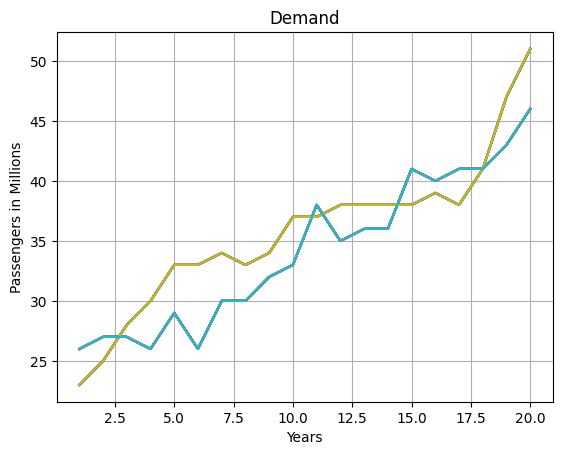

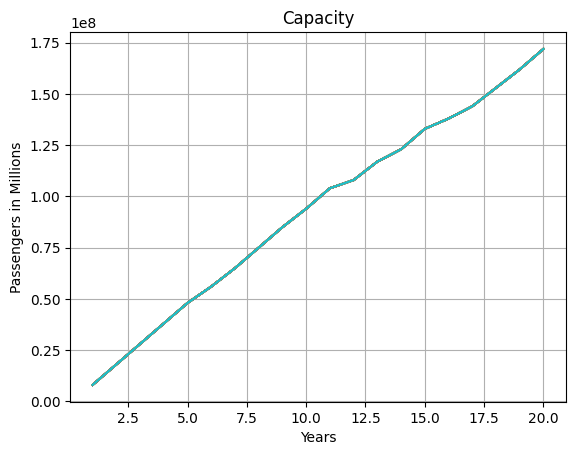

<Figure size 640x480 with 0 Axes>

In [140]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    np.ceil(Demand / 1000000),
    Fth,
    True,
    "Demand",
    "Passengers in Millions",
    30,
)

New_K = Capacity(25, best_ind)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    New_K,
    Fth,
    True,
    "Capacity",
    "Passengers in Millions",
    30,
)

In [141]:
# Parameters
r_D = 0.1  # Revenues per Unit of Demand per Period
r_K = 7  # Revenues per Unit of Capacity per Period
r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
co_K = 0.34  # Operational costs per unit of capacity per period
co_D = 0  # Operational cost per unit of demand per period
ci_K = 600000  # Installation cost per unit of capacity
discount = 0.05  # Discount factor
EoS = 0.9  # EoS factor
# delta_K0 = 0
h = 1
K0 = 25000000

# Demand
D_rounded = np.ceil(Demand / 1000000)
D2 = D_rounded * 1000000

# Capacity Vector
K2 = Capacity(K0, best_ind * 1000000)

# Revenue
Rev = Revenue(K2, D2, r_K, r_K_rent, r_D)
# Cost
Cos = Cost(K2, D2, delta_K, co_K, co_D, ci_K, EoS, h)

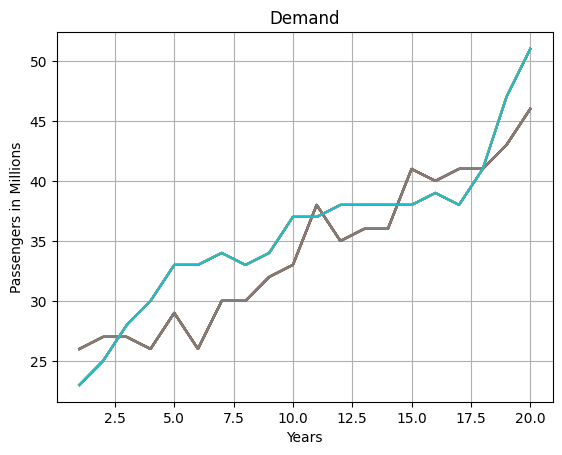

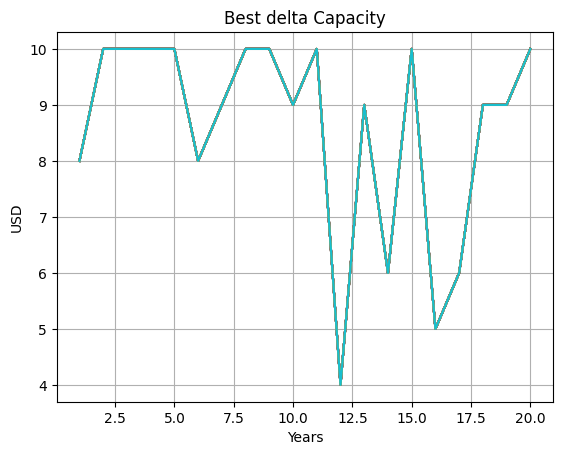

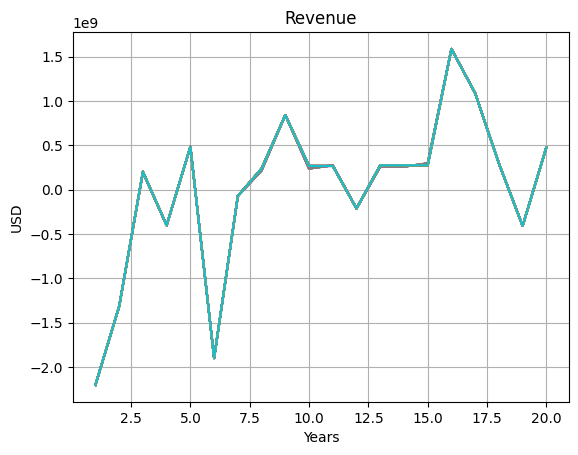

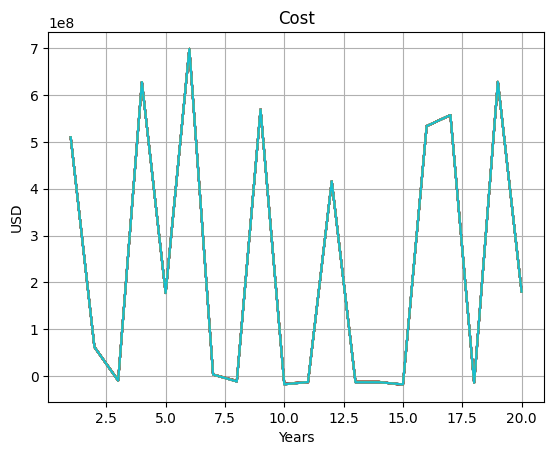

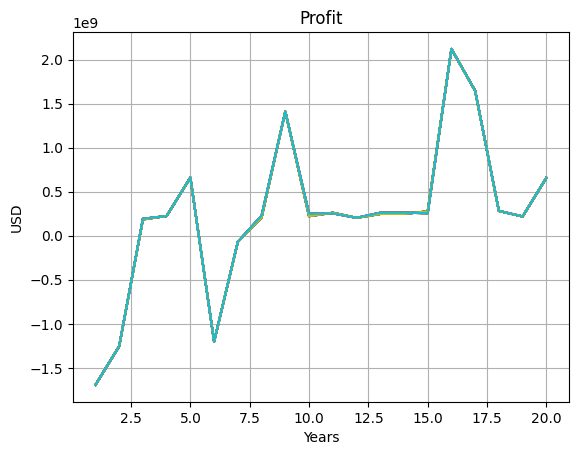

<Figure size 640x480 with 0 Axes>

In [142]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    np.ceil(Demand / 1000000),
    Fth,
    True,
    "Demand",
    "Passengers in Millions",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    best_ind,
    Fth,
    True,
    "Best delta Capacity",
    "USD",
    30,
)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Rev,
    Fth,
    True,
    "Revenue",
    "USD",
    30,
)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    -Cos,
    Fth,
    True,
    "Cost",
    "USD",
    30,
)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Rev - Cos,
    Fth,
    True,
    "Profit",
    "USD",
    30,
)

### Stopping the Runtime

In [143]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", total_run_time)

Total Runtime = 1.7885761260986328
